In [1]:
import cv2 as cv
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


## Read, Write, and Show

Keep in mind to add 'cv.destroyAllWindows()' to close opencv windows. 

Closing a window by red cross will make Jupyter notebook crash (describe [here](https://medium.com/@mrdatainsight/how-to-use-opencv-imshow-in-a-jupyter-notebook-quick-tip-ce83fa32b5ad)).

In [2]:
def imshow(image, title='display', cv_or_pyplot='pyplot'):
    """Wrapper for cv.imshow

    Args:
        title (str): title for the display window
        image (cv Mat object): image to show
        cv_or_pyplot (str): 'cv' for cv.imshow() and 'pyplot' for pyplot.imshow()

    Returns:
        str: the key pressed in image display window for cv.show()
    """
    
    if cv_or_pyplot == 'pyplot':
        if len(image.shape) <= 2:
            plt.imshow(cv.cvtColor(image, cv.COLOR_GRAY2RGB))
        else:
            plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
        return None
    elif cv_or_pyplot == 'cv':
        cv.imshow(title, image)
        input_key = cv.waitKey(0)
        cv.destroyAllWindows()
        return chr(input_key)

def stack_images(images, vertical_or_horizontal='h'): 
    images_3channel = []
    for image in images:
        if len(image.shape) <= 2:
            tmp = cv.cvtColor(image, cv.COLOR_GRAY2BGR)
        else:
            tmp = image
        images_3channel.append(tmp)
        
    if vertical_or_horizontal == 'h':
        return np.hstack(tuple(images_3channel))
    elif vertical_or_horizontal == 'v':
        return np.vstack(tuple(images_3channel))


Read, write and show a test image.

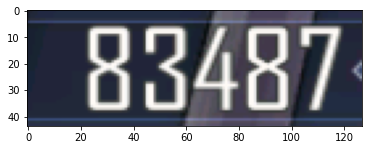

In [3]:
image_file_name = 'image/image_83487.png'
image = cv.imread(image_file_name, )
if image is None:
    sys.exit(f'Fail to read the image: {image_file_name}')

input_key = imshow(image)

if input_key == 's': # save
    image_save_file_name = 'test.png'
    cv.imwrite(image_save_file_name, image)

# Boxing Digits

Transform from a color image to a binary image.

Note that background should be black and target should be white for contour calculation involved in boxing.

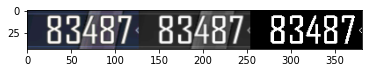

In [4]:
#image_file_name = 'image/image_352.png'
threshold = 140
assigned_value = 255

image_color = cv.imread(image_file_name, cv.IMREAD_COLOR)
image_gray = cv.cvtColor(image_color, cv.COLOR_BGR2GRAY)
image_threshold = cv.threshold(image_gray, threshold, assigned_value, cv.THRESH_BINARY)[1]
#image_binary = cv.bitwise_not(image_threshold) # invert black and white
image_binary = image_threshold

input_key = imshow(stack_images([image_color, image_gray, image_binary]))


Calculate the bounding box for the whole image (just for test)

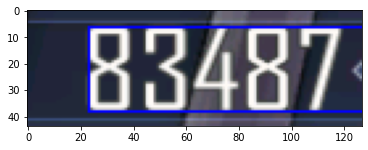

In [5]:
x1, y1, w, h = cv.boundingRect(image_binary)
x2 = x1 + w
y2 = y1 + h

box_line_thickness = 1
box_line_color = (255, 0, 0)
image_with_box = image_color.copy()
cv.rectangle(image_with_box, (x1, y1), (x2, y2), box_line_color, box_line_thickness)
key = imshow(image_with_box)

Calculate contours and get the bounding boxes for each digit

Found 6 contours(s)
Contour 0: from (124, 20) to (127, 26)
Contour 1: from (104, 6) to (119, 38)
Contour 2: from (84, 6) to (99, 38)
Contour 3: from (63, 6) to (80, 38)
Contour 4: from (45, 6) to (60, 38)
Contour 5: from (23, 6) to (39, 38)


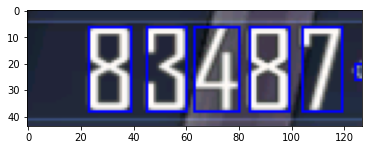

In [6]:
contours, hierachy = cv.findContours(image_binary, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
image_with_box = image_color.copy()
print(f'Found {len(contours)} contours(s)')
class point_2d():
    def __init__(self, x_start, y_start, x_end, y_end) -> None:
        self.x_start = x_start
        self.y_start = y_start
        self.x_end = x_end
        self.y_end = y_end
bounding_point_start_and_end = [None]*len(contours)
for i, contour in enumerate(contours):
    x1, y1, w, h = cv.boundingRect(contour)
    x2 = x1 + w
    y2 = y1 + h
    bounding_point_start_and_end[i] = point_2d(x1, y1, x2, y2)
    cv.rectangle(image_with_box, (x1, y1), (x2, y2), box_line_color, box_line_thickness)
    print(f'Contour {i}: from ({x1}, {y1}) to ({x2}, {y2})')
    #cv.imwrite()
key = imshow(image_with_box)

Save images for each digits

Last image:
Image size (y, x, channel): (32, 16, 3)


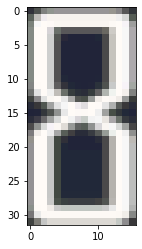

In [7]:

for i, digit in enumerate(bounding_point_start_and_end):
    point = bounding_point_start_and_end[i]
    image_cropped = image_color[point.y_start:point.y_end, point.x_start:point.x_end].copy()
    save_file_name = f'test_{i}.png'
    cv.imwrite(save_file_name, image_cropped)
    #print('Image size (y, x, channel):', image_cropped.shape)
print('Last image:')
key = imshow(image_cropped)
print('Image size (y, x, channel):', image_cropped.shape)

# Pack into Dataframe

Resize

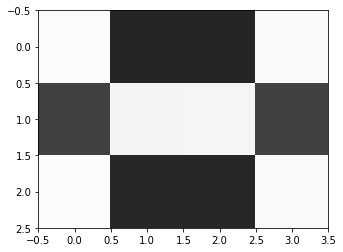

In [22]:
#train_folder = 'image/train/'

width = 4
height = 3
channel = 1
image = cv.imread('image/train/8_2.png', cv.IMREAD_GRAYSCALE)
image = cv.resize(image, (width, height))
imshow(image)

Save to numpy array

In [27]:
# get required shape of numpy array
number_of_image = 2
if channel == 1:
    shape_of_image = (number_of_image, height, width)
else:
    shape_of_image = (number_of_image, height, width, channel)
image_data = np.zeros(shape=shape_of_image)
print('Shape of packed image data', image_data.shape)

# pack all images into the numpy array
for i in range(number_of_image):
    image_data[i] = image
type(image_data[1])
#imshow(image_data[0])

# save to numpy file

Shape of packed image data (2, 3, 4)


numpy.ndarray

Read into dataframe

In [9]:
d = dict()
for i in range(width):
    for j in range(height):
        d[f"p_{i}_{j}"] = [int(image[j, i])]
df = pd.DataFrame(d)

In [10]:
df

,p_0_0,p_0_1,p_0_2,p_0_3,p_0_4,p_0_5,p_0_6,p_0_7,p_1_0,p_1_1,...,p_6_6,p_6_7,p_7_0,p_7_1,p_7_2,p_7_3,p_7_4,p_7_5,p_7_6,p_7_7
0,164,193,193,75,145,199,199,185,245,229,...,215,245,176,209,209,77,153,218,218,199


# Reference
[OpenCV tutorial: creating bounding boxes](https://docs.opencv.org/3.4/da/d0c/tutorial_bounding_rects_circles.html)

[Contour Features in OpenCV](https://docs.opencv.org/3.4/dd/d49/tutorial_py_contour_features.html)